In [829]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [830]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [831]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [832]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [833]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
214529,2012056,/m/06dz71,1945,Francesco,NaN,M,NaN,NaN,Francesco Grandjacquet,NaN,/m/0gbz224,/m/0ghwg66,/m/0gbz226
295994,22643646,/m/05zmxqt,1936,NaN,NaN,F,NaN,NaN,Elly Sternheim,NaN,/m/0kc39hb,NaN,/m/0kc39hf
53974,32710519,/m/0h3mx6f,2007-02-06,NaN,1987-10-15,F,NaN,NaN,Chantal Strand,19.0,/m/0h40llv,NaN,/m/07gl2p
240459,16426024,/m/03y0z_g,1987-12-16,NaN,NaN,M,NaN,NaN,Marc Smith,NaN,/m/0gd106_,NaN,/m/02z4s68
362937,26400881,/m/09vq_s5,2009,Irene Fox,1980-06-24,F,1.72,/m/041rx,Liane Balaban,28.0,/m/09vwzsp,/m/09vwzsm,/m/02pn4z4


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB top 1000 data

This dataset includes IMDB top 1,000 movies of all time with attributes such as Title, Certificate, Duration, Genre, etc.
source: https://www.kaggle.com/datasets/omarhanyy/imdb-top-1000

- Poster_Link
- Series_Title: Title of movie
- Release_year: Movie release year
- Certificate
- Runtime [min]
- Genre
- IMDB_Rating: IMDB rating over 10
- Overview: brief summary
- Meta_score: rating by critiques
- Director
- Star 1, 2, 3, 4
- No_of_Votes: Number of votes
- Gross: Revenue in the first 5 days of release

In [834]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [835]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: ????

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue during first 5 days of release
- Worldwide Gross: Gross revenue overall

In [836]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [837]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
726,Green Book,2018,8.2,PG-13,130,"Biography, Comedy, Drama","Nov 16, 2018",23000000,85080171,319543432
3625,Eulogy,2004,6.6,R,91,"Comedy, Drama","Oct 15, 2004",10000000,70527,70527
2900,The Scarlet Letter,1995,5.3,R,135,"Drama, Romance","Oct 13, 1995",50000000,10359006,10359006
3028,Miracle at St. Anna,2008,6.1,R,160,"Action, Drama, War","Sep 26, 2008",45000000,7916887,9676497
95,The Hobbit: The Desolation of Smaug,2013,7.8,PG-13,161,"Adventure, Fantasy","Dec 12, 2013",250000000,258241522,960238087


In [838]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/extract_wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `date`: date in format *yyyymmddHH*
- `pageviews`: Number of page views for a movie with `name` on a `date`


In [839]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [840]:
wikipedia_pageviews.head()

,movie_name,date,pageviews
0,Avengers: Endgame,2018042600,27
1,Avengers: Endgame,2018042700,115
2,Avengers: Endgame,2018042800,154
3,Avengers: Endgame,2018042900,141
4,Avengers: Endgame,2018043000,59


# Cleaning & Pre-processing of data

In [841]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [842]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [843]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [844]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [845]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [846]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [847]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [848]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [849]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [850]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [851]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [852]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [853]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [854]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [855]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [856]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [857]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [858]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [859]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [860]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [861]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [862]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

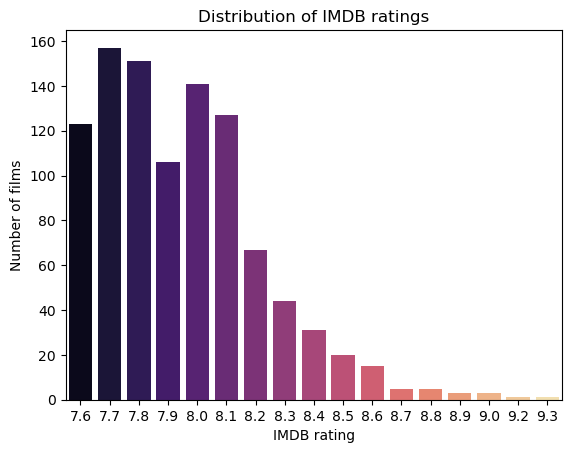

In [863]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000, palette="magma").set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films');


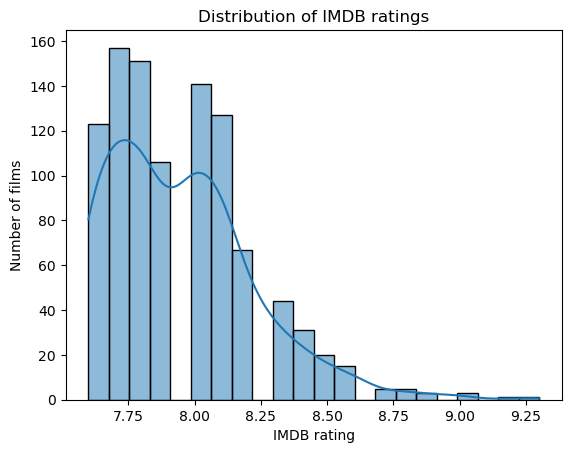

In [864]:
sns.histplot(x='IMDB_Rating', data = imdb_top_1000, kde=True).set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films');


In [865]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = imdb_top_1000['No_of_Votes'].min()
v = imdb_top_1000['No_of_Votes']
R = imdb_top_1000['IMDB_Rating']

In [866]:
imdb_top_1000['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [867]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=False).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
0,The Shawshank Redemption,9.3,9.285691,2343110
1,The Godfather,9.2,9.180931,1620367
2,The Dark Knight,9.0,8.988679,2303232
3,The Godfather: Part II,9.0,8.977178,1129952
4,12 Angry Men,9.0,8.963129,689845


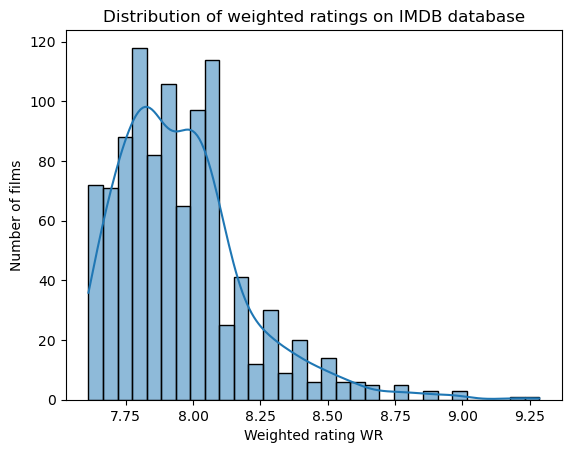

In [868]:
sns.histplot(x='WR', data = imdb_top_1000, kde=True).set(title='Distribution of weighted ratings on IMDB database',xlabel='Weighted rating WR', ylabel='Number of films');


### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [869]:
len((imdb_top_1000['Series_Title'] + imdb_top_1000['Released_Year'].astype(str)).unique()) / len(imdb_top_1000)

1.0

In [870]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [871]:
imdb_top_1000.rename({'Series_Title': 'name', 'Released_Year': 'release_year'}, axis=1, inplace=True)

In [872]:
imdb_top_1000.loc[imdb_top_1000['name'] == 'Apollo 13', 'release_year'] = '1995' # The release year was wrong in the dataset change from PG to 1995 /year was obtained from wikipedia/
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float').astype('Int16')
imdb_top_1000['release_year'] = imdb_top_1000['release_year'].replace('nan', np.nan).astype('float').astype('Int16')


In [873]:
movie_feature = imdb_top_1000.merge(movies, on=['name', 'release_year'], how='outer')


In [874]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [875]:
movie_feature['Genre'] = movie_feature['Genre'].replace(np.nan, '').apply(lambda x: x.split(', '))

fill_NaN(movie_feature,'runtime','Runtime')
fill_NaN(movie_feature,'genres','Genre')
movie_feature.drop(labels=['Runtime','Genre'], axis=1, inplace=True)

In [876]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [877]:
movie_feature.sample(3)

,Poster_Link,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,WR,wikipedia_id,freebase_id,box_office_revenue,runtime,languages,countries,genres,release_month,release_day
15569,NaN,Aadmi,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30033474.0,/m/0g53qzb,NaN,140.0,[Hindi],NaN,"[Crime Fiction, Romance Film, Action, Drama]",10,1
17059,NaN,About Red Cap,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31662421.0,/m/0gmctnn,NaN,135.0,[Russian],[Soviet Union],"[Musical, Fantasy, Adventure]",<NA>,<NA>
42731,NaN,Top of the World,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3291655.0,/m/093q40,NaN,99.0,[English],[United States of America],"[Thriller, Psychological thriller, Action/Adve...",<NA>,<NA>


In [878]:
movie_feature.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_month,release_day
count,75235.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02,1000.000000,8.174000e+04,8.401000e+03,61695.000000,42666.000000,39372.000000
mean,1977.602419,7.949300,77.971530,2.736929e+05,6.803475e+07,7.957808,1.740801e+07,4.799363e+07,93.842314,6.692495,15.651656
std,29.115190,0.275491,12.376099,3.273727e+05,1.097500e+08,0.242824,1.098786e+07,1.121753e+08,51.436090,3.483249,8.715623
min,1010.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,7.611562,3.300000e+02,1.000000e+04,0.000000,1.000000,1.000000
25%,1956.000000,7.700000,70.000000,5.552625e+04,3.253559e+06,7.799293,7.323722e+06,2.083193e+06,81.000000,4.000000,8.000000
50%,1985.000000,7.900000,79.000000,1.385485e+05,2.353089e+07,7.913042,1.777899e+07,1.063969e+07,93.000000,7.000000,16.000000
75%,2004.000000,8.100000,87.000000,3.741612e+05,8.075089e+07,8.077983,2.715589e+07,4.071696e+07,107.000000,10.000000,23.000000
max,2020.000000,9.300000,100.000000,2.343110e+06,9.366622e+08,9.285691,3.750192e+07,2.782275e+09,5100.000000,12.000000,31.000000


In [879]:
print(f'There are {(imdb_top_1000.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 603 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81740.


In [880]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

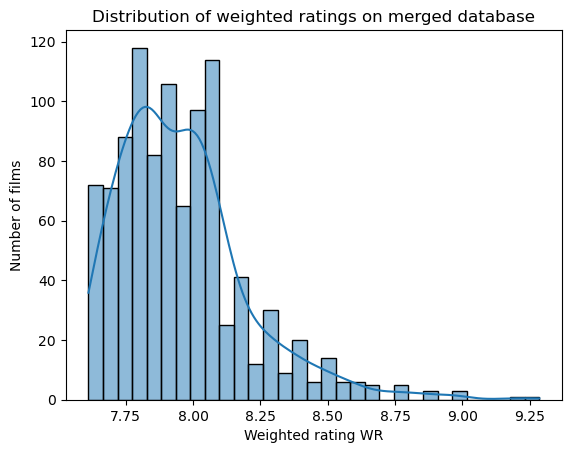

In [881]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [884]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

0.9977476654857129

### Fill missing budget data from imdb budget dataset

In [885]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
3007,Johnny English Reborn,2011,6.3,PG,101,"Action, Adventure, Comedy","Oct 21, 2011",45000000,8406711,164640401
968,Hidalgo,2004,6.7,PG-13,136,"Action, Adventure, Biography","Mar 5, 2004",78000000,67286731,108086731
938,Seven Pounds,2008,7.6,PG-13,123,Drama,"Dec 19, 2008",54000000,69951824,166617328
2101,Glory,1989,7.8,R,122,"Biography, Drama, History","Dec 13, 1989",18000000,26828365,26828365
2945,Everyone Says I Love You,1996,6.7,R,101,"Comedy, Musical, Romance","Dec 6, 1996",20000000,9725847,34600000


In [886]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [887]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [888]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [889]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767740,3.378479,8.437532
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [890]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9232380047968638

In [891]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [892]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [911]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [912]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [913]:
fill_NaN(movie_feature_with_budget,'genres_x','genres_y','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'Certificate','Rating')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')
fill_NaN(movie_feature_with_budget,'IMDB_Rating','IMDb')

### Investigate the gross difference between the original and the imdb budget datasets

In [ ]:
(movie_feature_with_budget['Gross'] - movie_feature_with_budget['Domestic Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the gross data from the two datasets')

In [ ]:
((movie_feature_with_budget['Gross'] - movie_feature_with_budget['Domestic Gross']) / movie_feature_with_budget['Gross']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the gross data from the two datasets')

In [ ]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total gross data from the two datasets')

In [ ]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['Gross'] - movie_feature_with_budget_differences['Domestic Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['Gross'] - movie_feature_with_budget['Domestic Gross']) / movie_feature_with_budget['Gross']) * 100).round(2)

In [ ]:
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference', ascending=False) \
    [['name', 'Gross', 'box_office_revenue', 'Production Budget', 'Domestic Gross', 'Worldwide Gross', 'profit', 'gross_difference']]

In [ ]:
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference%'] != 0) & (~movie_feature_with_budget_differences['gross_difference%'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'Gross', 'box_office_revenue', 'Production Budget', 'Domestic Gross', 'Worldwide Gross', 'profit', 'gross_difference', 'gross_difference%']]

 ### ADD SENTENCE TO MAKE THE LINK WITH BELOW

In [914]:
fill_NaN(movie_feature_with_budget,'box_office_revenue','Worldwide Gross','total_gross')
fill_NaN(movie_feature_with_budget,'Domestic Gross','Gross','release_gross')

In [915]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'genre', 'release_day',
       'release_month', 'total_gross', 'release_gross'],
      dtype='object')

In [916]:
# Remove merged extra columns 
movie_feature_with_budget.drop(['box_office_revenue', 'Worldwide Gross','Domestic Gross','Gross','Rating',
                                'Runtime','IMDb','release_month_x','release_month_y','release_day_x',
                                'release_day_y','genres_x','genres_y'], axis=1, inplace=True)

# Remove data that won't be used in the analysis
movie_feature_with_budget.drop(['Poster_Link'], axis=1, inplace=True) 

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [917]:
movie_feature_with_budget.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'Production Budget', 'genre', 'release_day',
       'release_month', 'total_gross', 'release_gross', 'profit'],
      dtype='object')

In [918]:
movie_feature_with_budget.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,release_day,release_month,total_gross,release_gross,profit
count,76183.000000,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,40599.000000,43858.000000,9.774000e+03,4.242000e+03,3.841000e+03
mean,1978.059410,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,15.658834,6.707875,6.074096e+07,5.301440e+07,8.048839e+07
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,8.708488,3.483286,1.420196e+08,7.487188e+07,1.689107e+08
min,1010.000000,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,1.000000,1.000000,0.000000e+00,0.000000e+00,-1.580898e+08
25%,1956.000000,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,8.000000,4.000000,2.416735e+06,8.886709e+06,-8.058500e+04
50%,1986.000000,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,16.000000,7.000000,1.309217e+07,2.950556e+07,2.345074e+07
75%,2004.000000,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,23.000000,10.000000,5.207636e+07,6.500179e+07,8.985276e+07
max,2020.000000,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,31.000000,12.000000,2.797801e+09,9.366622e+08,2.545275e+09


In [920]:
movie_feature_with_budget.sample(5)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,runtime,languages,countries,Production Budget,genre,release_day,release_month,total_gross,release_gross,profit
34952,Blinky Bill,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90.0,[English],[Australia],NaN,[Animation],17,9,NaN,NaN,NaN
76775,Rancho Deluxe,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.0,[English],[United States of America],NaN,"[Action/Adventure, Western, Action, Comedy, Co...",<NA>,<NA>,NaN,NaN,NaN
16781,Horse Feathers,1932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,[English],[United States of America],NaN,"[Parody, Absurdism, Screwball comedy, Black-an...",<NA>,<NA>,NaN,NaN,NaN
53960,Fantastic Plastic Machine,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.0,[English],[United States of America],NaN,"[Sports, Extreme Sports, Documentary]",<NA>,5,NaN,NaN,NaN
22342,Portrait of a Hitman,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86.0,[English],[United States of America],NaN,"[Action, Drama]",<NA>,<NA>,NaN,NaN,NaN


## Account for inflation: 

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [922]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [923]:
df = movie_feature_with_budget.copy()

In [925]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['release_gross_modified'] = df['release_gross']

In [926]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'release_gross_modified'] = decade_df['release_gross'] * inflation_rate
   

In [935]:
movie_feature_with_budget = df.copy()

### Wikipedia pageviews

In [936]:
wikipedia_pageviews['date'] = pd.to_datetime(wikipedia_pageviews['date'], format='%Y%m%d%H')

In [937]:
wikipedia_pageviews.sample(5)

,movie_name,date,pageviews
1667016,The Color Purple,2017-07-07,971
1023422,Alvin and the Chipmunks: Chipwrecked,2020-04-19,847
1565373,Scream 2,2018-11-16,1146
711766,Hannibal,2019-09-22,2428
590625,Pretty Woman,2020-10-09,2208


In [938]:
wikipedia_pageviews.describe()

,pageviews
count,2.301748e+06
mean,1.688527e+03
std,6.576590e+03
min,0.000000e+00
25%,1.170000e+02
50%,8.810000e+02
75%,1.891000e+03
max,1.982874e+06


In [939]:
wikipedia_pageviews.rename({'movie_name': 'name'}, axis=1, inplace=True)

In [940]:
wikipedia_pageviews_mean_per_day = wikipedia_pageviews.groupby('name').mean()
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews_mean_per_day, on='name', how='left')

In [941]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,release_day,release_month,total_gross,release_gross,profit,profit_modified,total_gross_modified,release_gross_modified,pageviews
count,76183.000000,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,40599.000000,43858.000000,9.774000e+03,4.242000e+03,3.841000e+03,3.841000e+03,9.774000e+03,4.242000e+03,1198.000000
mean,1978.059410,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,15.658834,6.707875,6.074096e+07,5.301440e+07,8.048839e+07,1.024064e+08,7.894308e+07,6.840778e+07,1629.608527
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,8.708488,3.483286,1.420196e+08,7.487188e+07,1.689107e+08,2.108261e+08,1.788578e+08,9.548470e+07,2306.323344
min,1010.000000,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,1.000000,1.000000,0.000000e+00,0.000000e+00,-1.580898e+08,-1.887276e+08,0.000000e+00,0.000000e+00,0.833333
25%,1956.000000,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,8.000000,4.000000,2.416735e+06,8.886709e+06,-8.058500e+04,-9.548848e+04,3.239444e+06,1.153954e+07,96.998887
50%,1986.000000,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,16.000000,7.000000,1.309217e+07,2.950556e+07,2.345074e+07,3.104707e+07,1.809463e+07,3.766104e+07,963.526160
75%,2004.000000,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,23.000000,10.000000,5.207636e+07,6.500179e+07,8.985276e+07,1.155830e+08,7.089055e+07,8.452512e+07,2170.703618
max,2020.000000,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,31.000000,12.000000,2.797801e+09,9.366622e+08,2.545275e+09,3.265843e+09,3.569937e+09,1.118187e+09,37415.568125


# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(movie_feature_with_budget.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Success indicators: 

- IMDB rating -> weighted rating : WR 
- gross revenue (15000 types) 
- wikipedia ID connection query : how much a movie lasts in time
- profit = revenue - budget 

1. correlation btw success indicators 
2. Check if we have the same successful movies & actors according to different indicators
3. Succesfulness = function (all indicators) 



Actor success: 
Weight in terms of number of apparearance and movie WR

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CAREFUL, WHY ARE RATINGS AND GROSS REVENUE COMPLETELY UNCORRELATED ? 

In [ ]:
df_release = movie_feature.dropna(how='all', subset=['release_month']) # Remove NaN months

In [ ]:
movies['release_month'].describe()

In [ ]:
df_release.columns

In [ ]:
df_release=df_release.sort_values(by='release_month', ascending=True)

In [ ]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Successfulness of Movie Release By Month', fontsize=14)

In [ ]:
df_release.columns

In [ ]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="box_office_revenue_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Box office revenue', fontsize=12)
plt.title('Successfulness in terms of box office revenue of Movie Release By Month', fontsize=14)

In [ ]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="Gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Gross revenue', fontsize=12)
plt.title('Successfulness in terms of gross revenue of Movie Release By Month', fontsize=14)

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare maintly three features, the budget spent 'Production Budget', the profit made 'profit' and the rating of the movie to account for successfulness.

CHECK FOR SUCCESSFULNESS. 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate

In [ ]:
movie_feature_with_budget.columns

In [ ]:
min(movie_feature_with_budget['Released_Year'])

In [ ]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit_modified', kind="reg");



To do : Split between high budget movies and average budget and check same graph 

The positive trend line indicates that an increase in the budget will result in an increase in profit.

In [ ]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit_modified', kind="hex");


In [ ]:
sns.pairplot(movie_feature_with_budget[['Production Budget','profit','WR']])

In [ ]:
Top20_ProfitableMovies = movie_feature_with_budget.sort_values('profit', ascending=False).head(20)

Profit margin 

In [ ]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Impact of director

In [ ]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

In [ ]:
Top20_ProfitableMovies['Director']

## Impact of actors

HOW TO ACCOUNT FOR DIFFERENT ACTORS ??? only Star1

In [ ]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [ ]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

In [ ]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

In [ ]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

## What genres are the most profitable?

In [ ]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

In [ ]:
movie_feature_with_budget['profit'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution')

In [ ]:
movie_feature_with_budget['genre1'] = movie_feature_with_budget['genres'].apply(lambda el: el[0])

In [ ]:
movie_feature_with_budget['genre1'].value_counts().plot(kind='bar', title='Movie genres distribution')

In [ ]:
def visualize_genres_profit(genres, means, p025s, p975s, axis, title):
    axis.errorbar(
        np.arange(len(genres)),
        means,
        xerr=0.5,
        yerr=[means - p025s, p975s - means],
        linestyle='', alpha=0.7, color='teal'
    )

    axis.set_title(title)
    print(genres)
    ax.set_xticks(np.arange(len(genres)))
    axis.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(genres))))
    axis.set_xticklabels(genres, rotation=90)


In [ ]:
def calculate_average_difference_95_ci(data):
    average_difference = np.mean(data)
    ci_95 = np.percentile(data, [2.5, 97.5])

    return average_difference, ci_95

In [ ]:
profit = movie_feature_with_budget.groupby('genre1').agg({'profit': calculate_average_difference_95_ci})['profit']

profit_mean = profit.str[0]
profit_p025 = profit.str[1].str[0]
profit_p975 = profit.str[1].str[1]

figure, axis = plt.subplots(1, 1)
visualize_genres_profit(profit_mean.index, profit_mean, profit_p025, profit_p975, axis, 'Average profit per genre')

## correlation between the choice of topics and movie profitability can be investigated

In [ ]:
movie_feature_with_budget['genre1_category'] = movie_feature_with_budget['genre1'].astype('category').cat.codes

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(movie_feature_with_budget.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [ ]:
wikipedia_pageviews.sample(5)

In [ ]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Spy Kids'].plot(x='date', y='pageviews', title='Pageviews for Spy Kids')

In [ ]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Avengers: Endgame'].plot(x='date', y='pageviews', logy=True, title='Pageviews for Avengers: Endgame')

In [ ]:
movie_feature_with_budget_and_wikipedia_pageviews.sample(5)

In [ ]:
movie_feature_with_budget_and_wikipedia_pageviews.columns

In [ ]:
movie_feature_with_budget_and_wikipedia_pageviews['release_year'] = movie_feature_with_budget_and_wikipedia_pageviews['release_year'].astype(int)

In [ ]:
mod = smf.ols(formula='pageviews ~ release_year + runtime + WR + Director + Star1 + Star2 + Star3 + Star4 + Gross + profit + genre1', data=movie_feature_with_budget_and_wikipedia_pageviews[movie_feature_with_budget_and_wikipedia_pageviews['release_year'] < (2015-15)])
np.random.seed(2)
res = mod.fit()
res.summary()